In [1]:
# import packages
import sys
import os.path
import numpy as np
np.seterr(divide='ignore',invalid='ignore')
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns
sns.set()

from spykshrk.realtime.datatypes import Datatypes
import loren_frank_data_processing as lfdp
from loren_frank_data_processing import Animal
import trodes2SS
import scipy as sp
import sungod_util
from spykshrk.franklab.data_containers import RippleTimes, pos_col_format#FlatLinearPosition, SpikeFeatures, Posteriors, \
         #EncodeSettings, pos_col_format, SpikeObservation, RippleTimes, DayEpochEvent, DayEpochTimeSeries

%load_ext autoreload
%autoreload 2

idx = pd.IndexSlice
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 120)

In [ ]:
# cell to start up holoviews
import holoviews as hv

import scipy as sp

hv.extension('bokeh')

In [ ]:
# cell to test and make sure holoviews and bokeh are working
coords = np.random.rand(50,2)
points = hv.Points(coords)

points.opts(color='k', marker='+', size=10)

In [13]:
# cell to read real-time hdf5 file

#12-17, bill run session 3
#hdf_file = '/stelmo/mcoulter/spykshrk_output/bill/20191217_bill_05_r3_westerlies_streaming.rec_merged.h5'

# new pos/vel and fix prob no spike
hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_2_13_prob_no.rec_merged.h5'

# 2-19 trodes 2 spike fix
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_2_19_spike_fix_whole.rec_merged.h5'

store = pd.HDFStore(hdf_file, mode='r')

In [3]:
# 2-19 trodes spike fix
encoder_data = store['rec_3']
decoder_data = store['rec_4']
decoder_missed_spikes = store['rec_5']
likelihood_data = store['rec_6']
occupancy_data = store['rec_7']
ripple_data = store['rec_1']
#stim_state = store['rec_10']
stim_lockout = store['rec_11']
stim_message = store['rec_12']
timing = store['rec_100']

In [14]:
# 2-13 new pos/vel and prob_no_spike
encoder_data1 = store['rec_3']
decoder_data1 = store['rec_4']
decoder_missed_spikes1 = store['rec_5']
likelihood_data1 = store['rec_6']
occupancy_data1 = store['rec_7']
ripple_data1 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout1 = store['rec_11']
stim_message1 = store['rec_12']
timing1 = store['rec_100']

In [ ]:
encoder_data1

In [6]:
#this is the most recent offline decode
file_path = '/stelmo/mcoulter/oct_2019_decoding/remy_20_2_shuffle_0_posteriors_functionalized_150_decode_whole.h5'
hdf_base = '/analysis'
hdf_grps = 'decode/clusterless/offline/posterior'
hdf_label = 'sungod_trans_mat'

with pd.HDFStore(file_path, 'r') as store:
    main_path = os.path.join(hdf_base, hdf_grps, hdf_label)
    posteriors2 = store[main_path]

In [7]:
# get linear position for offline
#### Define parameters
rat_name = 'remy'
day =  20     #previously:{'remy':[20], 'gus':[28], 'bernard':[23], 'fievel':[19]}
epoch = 2   # previously:{'remy':[4], 'gus':[2], 'bernard':[4], 'fievel':[2]} 

# define data source filepaths
path_base = '/stelmo/mcoulter/'
#path_base = '/mnt/vortex/mcoulter/'
raw_directory = path_base + 'raw_data/' + rat_name + '/'
linearization_path = path_base + 'maze_info/'
day_ep = str(day) + '_' + str(epoch)

#tetlist = None
tetlist = [4]
tetrodes= tetlist

pos_bin_size = 5
velocity_thresh_for_enc_dec = 4
velocity_buffer = 0
shift_amt_for_shuffle = 0
use_enc_as_dec = 1   #if you want to use the encoding marks as the decoding marks
discrete_tm_val=.99   # for classifier

# IMPORT and process data
#initialize data importer
datasrc = trodes2SS.TrodesImport(raw_directory, rat_name, [day], 
                       [epoch], tetrodes)
# Import trials
trials = datasrc.import_trials()
# Import raw position
linear_pos_raw = datasrc.import_pos(xy='x')   # this is basically just to pull in speed, will be replaced with linearized below
#posY = datasrc.import_pos(xy='y')          #  OPTIONAL; useful for 2d visualization

# if linearization exists, load it. if not, run the linearization.
lin_output1 = linearization_path + rat_name + '/' + rat_name + '_' + day_ep + '_' + 'linearized_distance.npy'
lin_output2 = linearization_path + rat_name + '/' + rat_name + '_' + day_ep + '_' + 'linearized_track_segments.npy'
linear_pos_raw['linpos_flat'] = np.load(lin_output1)   #replace x pos with linerized 
track_segment_ids = np.load(lin_output2)
print('Linearization found. Loading it')

#if os.path.exists(lin_output1) == False:
#    print('Linearization result doesnt exist. Doing linearization calculation')
#    sungod_util.run_linearization_routine(rat_name, day, epoch, linearization_path, raw_directory, gap_size=20)
#    linear_pos_raw['linpos_flat'] = np.load(lin_output1)
#    track_segment_ids = np.load(lin_output2)
#else: 

# generate boundary definitions of each segment
arm_coords, _ = sungod_util.define_segment_coordinates(linear_pos_raw, track_segment_ids)  # optional addition output of all occupied positions (not just bounds)

#bin linear position 
binned_linear_pos, binned_arm_coords, pos_bins = sungod_util.bin_position_data(linear_pos_raw, arm_coords, pos_bin_size)

# Import ripples
rips_tmp = datasrc.import_rips(linear_pos_raw, velthresh=4) 
rips = RippleTimes.create_default(rips_tmp,1)  # cast to rippletimes obj
print('Rips less than velocity thresh: '+str(len(rips)))

Linearization found. Loading it
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  64.
  69.  74.  79.  84.  89.  94.  99. 104. 109. 114. 119. 124. 129. 134.
 139. 144. 147. 152. 157. 162. 167. 172. 177. 182. 187. 192. 197. 202.
 207. 212. 217. 222. 227. 232. 237. 242. 247. 252. 257. 262. 267. 272.
 277. 282. 287. 292. 297. 302. 307. 312. 317. 319. 324. 329. 334. 339.
 344. 349. 354. 359. 364. 369. 374. 379. 384. 389. 394. 399. 403. 408.
 413. 418. 423. 428. 433. 438. 443. 448. 453. 458. 463. 468. 473. 478.
 483. 485. 490. 495. 500. 505. 510. 515. 520. 525. 530. 535. 540. 545.
 550. 555. 560. 565. 568. 573. 578. 583. 588. 593. 598. 603. 608. 613.
 618. 623. 628. 633. 638. 643. 648. 649. 654. 659. 664. 669. 674. 679.
 684. 689. 694. 699. 704. 709. 714.]
[[  0   8]
 [ 13  25]
 [ 30  42]
 [ 47  59]
 [ 65  77]
 [ 82  94]
 [ 99 111]
 [116 128]
 [133 145]]
Rips less than velocity thresh: 1256


In [ ]:
# merge posteriors and ripples for realtime data

# want to try to add both beginning of ripple and time bin when message was sent to decoder_data
# for stim_message this merge ('nearest') put the arm number and ripple number at all timebins after the end of the rippple
# for stim_lockout this merge ('backward') will highlight the ripple time
stim_message_1 = stim_message3.copy()
stim_message_2 = stim_message_1.drop(['rec_ind','spike_timestamp','lfp_timestamp','time',
                                   'ripple_time_bin','spike_count','delay',
                                   'content_threshold','max_arm_repeats','box','arm1','arm2',
                                   'arm3','arm4','arm5','arm6','arm7','arm8'], axis=1)
stim_message_2
decode_to_merge = decoder_data3.copy()
merged_decoder_stim = pd.merge_asof(decode_to_merge,stim_message_2,on='bin_timestamp',direction='nearest')
merged_decoder_stim

stim_lockout_1 = stim_lockout3.copy()
stim_lockout_1['bin_timestamp'] = stim_lockout3['timestamp']
stim_lockout_2 = stim_lockout_1.drop(['rec_ind','timestamp','time','lockout_num','tets_above_thresh',
                                      'big_rip_message_sent'], axis=1)
stim_lockout_2
##decode_to_merge = decoder_data1.copy()
merged_decoder_lockout = pd.merge_asof(merged_decoder_stim,stim_lockout_2,on='bin_timestamp',direction='backward')
merged_decoder_lockout

In [11]:
# subset of decoder_data to plot - loop through each ripple
# how can we just generate the images for the mismatched ripples??

realtime_posterior_sum_all = np.zeros((len(stim_lockout3[stim_lockout3['lockout_state']==1]),4))
counter = -1
summarize_all_rips = True

for timestamp in stim_lockout3[stim_lockout3['lockout_state']==1]['timestamp'][0:10].values:
    #counter += 1
    ##print(counter)
    #if counter in non_matching['realtime_rip'].values:
    #    print(counter)
    if summarize_all_rips:
    #print(timestamp-30*300,timestamp+30*300)
    #posterior from decode/stim message merged table
        merged_to_plot = merged_decoder_lockout[(merged_decoder_lockout['bin_timestamp'] > timestamp-30*300) & 
                                            (merged_decoder_lockout['bin_timestamp'] < timestamp+30*300)]
        merged_to_plot.set_index('bin_timestamp',inplace=True)

        posterior_only_merged = merged_to_plot.drop(['rec_ind','wall_time','velocity','real_pos',
                                                'spike_count','ripple','ripple_length','timestamp_shift',
                                                'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                                                'arm6','arm7','arm8','posterior_max_arm','shortcut_message_sent',
                                                'raw_x','raw_y','smooth_x','smooth_y','ripple_number_x',
                                                'ripple_number_y','ripple_end','lockout_state','lockout_num',
                                                'delay','next_bin'], axis=1)
        # ripple time - generated from lockout_state
        # lockout_state changes at posterior_lock end, so this should post_lock (now 50 msec)
        ripples_to_plot = merged_to_plot.reset_index()
        ripple_times_rt = ripples_to_plot.index[ripples_to_plot['lockout_state'] > 0].tolist()

        # get timestamp when shortcut message was sent - try to just isolate single ripple
        # bin_timestamp will show the delay - it will appear before the start of the ripple
        # in contrast, lfp_timestamp would line up exactly with ripple start
        shortcut_message_to_plot = stim_message3[(stim_message3['bin_timestamp'] > timestamp-30*30) & 
                                             (stim_message3['bin_timestamp'] < timestamp+30*100)]
        merged_to_plot_index = merged_to_plot.reset_index()
        # loop through multiple entries in shortcut_message
        shortcut_message_times = np.zeros(shortcut_message_to_plot.shape[0])
        for i in np.arange(0,shortcut_message_to_plot.shape[0]):
            shortcut_message_times[i] = merged_to_plot_index.index[merged_to_plot_index['bin_timestamp'].values == shortcut_message_to_plot['bin_timestamp'][i:i+1].values].tolist()[0]
        #shortcut_message_times = merged_to_plot_index.index[merged_to_plot_index['bin_timestamp'].values == shortcut_message_to_plot['bin_timestamp'].values].tolist()
        shortcut_messages = shortcut_message_to_plot['shortcut_message_sent'].values*123
    
        #posterior_only
        #print(posterior_only_merged.shape)
    
        #plot heatmap with posterior surrounding each ripple
        post_heatmap = posterior_only_merged.transpose()
        post_heatmap = post_heatmap.iloc[::-1]
    
        #plot title: include ripple number, max arm, and delay
        title_index = int(len(merged_to_plot)*0.6)
        max_arm = merged_to_plot[title_index:title_index+1]['posterior_max_arm'].values
        #ripple_num = merged_to_plot[-2:-1]['ripple_number_y'].values
        #f'Real-time posterior, ripple {max_arm}. Max arm {ripple_num}'
        #ripple_num = merged_to_plot[ripple_num_index:ripple_num_index+1]['ripple_number_y'].values
        ripple_num = merged_to_plot[title_index:title_index+1]['lockout_num'].values
        message_delay = np.around(merged_to_plot[title_index:title_index+1]['delay'].values,decimals=0)

        # fill in current row of posterior sum array - seems to work
        realtime_posterior_sum_all[counter,0] = ripple_num
        realtime_posterior_sum_all[counter,1] = max_arm
        realtime_posterior_sum_all[counter,2] = shortcut_message_to_plot.shape[0]-1
        realtime_posterior_sum_all[counter,3] = message_delay
    
        plt.figure(figsize=(12,5))
        plt.title(f'Real-time posterior, Ripple {ripple_num} Max arm {max_arm} Delay {message_delay}')
        ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
        #gap lines need to be inverse of where you would expect
        ax.hlines([135-9,135-25,135-41,135-57,135-73,135-89,135-105,135-121], lw=2, color='w',*ax.get_xlim())
        ax.scatter(np.arange(0,merged_to_plot.shape[0]),136-merged_to_plot['real_pos'].values,s=1,alpha=0.5,color='cyan')
        #ax.scatter(stim_lockout['timestamp'].values,(stim_lockout['lockout_state'].values)*50,s=2,alpha=1)
        ax.vlines(ripple_times_rt,lw=1,color='w',alpha=0.3,*ax.get_ylim())
        # plot time when statescript message was sent, 100 = sent, 0 = not send
        # if X is missing it means the timestamp didn't match perfectly above
        # could take delay into account here: add delay/5
        ax.scatter(shortcut_message_times+message_delay/5,124-shortcut_messages,s=40,color='yellow',marker='x')

        # try to find ripple number
        #ax.scatter(np.arange(0,merged_to_plot.shape[0]),136-merged_to_plot['ripple_number_y'].values+20,s=1,alpha=0.5,color='red')
        # need to convert sent_message_list into values starting where beginning of this plot is x=0
        #ax.vlines(100,lw=1,color='w',alpha=1,*ax.get_ylim())
    
        # final step: save the figure
        #plt.savefig(f'/stelmo/mcoulter/posterior_plots_by_ripple/2-4-20/remy_20_2_realtime_2_5_nonmatching_{ripple_num}_timestamp_{timestamp}.jpg')

# convert offline_posterior_sum_all array to pandas
realtime_post_sum_summary = pd.DataFrame(data=realtime_posterior_sum_all,columns=('realtime_rip','rt_max_arm',
                                                                                  'rt_two_messages','rt_delay'))
realtime_post_sum_summary.shape
# check numbering for ripples 4, 5, 6
# also, looks like it never switch to an outer arm if the decode starts in the box
# looks like many replays fail because it doesn't get 10 bins of data - this may be a result of empty bins

NameError: name 'merged_decoder_lockout' is not defined

In [9]:
# to match offline, add 1958987 to realtime timestamps
# shift for realtime ripple detection delay: subtract 2100
#45317550 45321300

realtime_rips = stim_lockout3[stim_lockout3['lockout_state']==1]
print('realtime rips',realtime_rips.shape)
offline_rips = rips.reset_index()
print('offline rips',offline_rips.shape)
offline_rips['adj_timestamp'] = offline_rips['timestamp']
realtime_rips['adj_timestamp'] = realtime_rips['timestamp']+1958987-2100
realtime_rips
# merge real-time and offline ripples 
# offline ripple start is 50-100 msec before real-time
# try a tolerance of 100 msec = 3000 timestamps
merged_ripple_times = pd.merge_asof(offline_rips,realtime_rips,on='adj_timestamp',tolerance=3000,direction='nearest')
matching_offline_rips = merged_ripple_times[merged_ripple_times['lockout_num']>0]
print(matching_offline_rips.shape)

realtime rips (694, 7)
offline rips (1256, 7)
(553, 15)


(array([ 13., 424.,  91.,  24.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

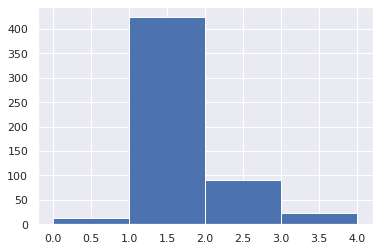

In [10]:
# shows number of offline ripples that match two realtime ripples (duplicates)
# look at value of 0 bin in histogram (23)
plt.hist(matching_offline_rips['lockout_num'].diff().values,bins=np.arange(0,5))

In [ ]:
# offline posteriors, 150 uV threshold
#offline arm ends 8, 25, 42, 59, 77, 94, 111, 128, 145 
arm_coords = [[0,8],[13,25],[30,42],[47,59],[65,77],[82,94],[99,111],[116,128],[133,145]]

# now need to plot offline ripples that are mismatched

posterior_offline = posteriors2.reset_index()
offline_pos = binned_linear_pos.reset_index()
merged_off_post_pos = pd.merge_asof(posterior_offline,offline_pos,on='timestamp',direction='nearest')
offline_posterior_sum_all = np.zeros((len(matching_offline_rips),12))

for index, rip_timestamp in enumerate(matching_offline_rips['timestamp_x']):
    if matching_offline_rips['lockout_num'][index:index+1].values in non_matching['realtime_rip'].values:
        print(matching_offline_rips['lockout_num'][index:index+1].values)
        #print(rip_timestamp-30*300,rip_timestamp+30*300,index)

        posterior_to_plot = merged_off_post_pos[(merged_off_post_pos['timestamp'] > rip_timestamp-30*300) & 
                                            (merged_off_post_pos['timestamp'] < rip_timestamp+30*300)]

        realtime_ripple_num = matching_offline_rips['lockout_num'][index:index+1].values
        ripple_num_index = int(len(posterior_to_plot)*0.55)
        ripple_num = posterior_to_plot[ripple_num_index:ripple_num_index+1]['ripple_grp'].values
    
        # calculate posterior sum during ripple
        # we need to only take out the time when ripple_grp matches ripple_grp at the middle of the plotting bin
    
        #post_sum_times = posterior_to_plot[posterior_to_plot['ripple_grp'] > 0]
        post_sum_times = posterior_to_plot[posterior_to_plot['ripple_grp'] == ripple_num[0]]
        ripple_length = post_sum_times.shape[0]
        # sum each arm over whole ripple
        post_sum_ripple = np.zeros((ripple_length,9))
        for i in np.arange(0,ripple_length):
            if i == 0:
                for j in np.arange(0,len(arm_coords),1):
                    post_sum_ripple[i,j] = post_sum_times.iloc[i,4:150].values[arm_coords[j][0]:arm_coords[j][1]].sum()

            else:
                for j in np.arange(0,len(arm_coords),1):
                    post_sum_ripple[i,j] = post_sum_ripple[i-1,j] + post_sum_times.iloc[i,4:150].values[arm_coords[j][0]:arm_coords[j][1]].sum()
            
        # normalize sum of whole ripple - this is the final row
        post_sum_ripple[i] = post_sum_ripple[i]/post_sum_ripple[i].sum()
    
        ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] > 0].tolist()

        posterior_offline1 = posterior_to_plot.drop(['day_x','epoch_x','timestamp','time_x','num_spikes','dec_bin',
                                                 'ripple_grp','day_y','epoch_y','time_y','linpos_flat',
                                                 'linvel_flat'], axis=1)

        posterior_offline2 = posterior_offline1.fillna(0)
        post_heatmap = posterior_offline2.transpose()
        post_heatmap = post_heatmap.iloc[::-1]

        posterior_sum = np.around(post_sum_ripple[-1:],decimals=1)
        posterior_sum = posterior_sum[0]
    
        if len(np.argwhere(posterior_sum>=0.5)):
            arm_max = np.argwhere(posterior_sum>=0.5)[0][0]
        else:
            arm_max = 99 

        # fill in current row of posterior sum array - seems to work
        offline_posterior_sum_all[index,0] = ripple_num
        offline_posterior_sum_all[index,1] = realtime_ripple_num
        offline_posterior_sum_all[index,2] = arm_max
        offline_posterior_sum_all[index,3] = posterior_sum[0]
        offline_posterior_sum_all[index,4] = posterior_sum[1]
        offline_posterior_sum_all[index,5] = posterior_sum[2]
        offline_posterior_sum_all[index,6] = posterior_sum[3]
        offline_posterior_sum_all[index,7] = posterior_sum[4]
        offline_posterior_sum_all[index,8] = posterior_sum[5]
        offline_posterior_sum_all[index,9] = posterior_sum[6]
        offline_posterior_sum_all[index,10] = posterior_sum[7]
        offline_posterior_sum_all[index,11] = posterior_sum[8]
                                     
        plt.figure(figsize=(12,5))
        plt.title(f'Off rip {ripple_num}. RT rip {realtime_ripple_num} Arm {arm_max} {posterior_sum}')
        ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
        ax.hlines([145-10,145-27,145-44,145-61,145-79,145-96,145-113,145-130], lw=2, color='w',*ax.get_xlim())
        ax.scatter(np.arange(0,posterior_to_plot.shape[0]),145-posterior_to_plot['linpos_flat'].values,s=2,alpha=1,color='cyan')
        ax.vlines([ripple_times-posterior_to_plot.index[0]],lw=1,color='w',alpha=0.2,*ax.get_ylim())
    
        # final step: save the figure
        #plt.savefig(f'/stelmo/mcoulter/posterior_plots_by_ripple/2-4-20/remy_20_2_offline_rip_nonmatching_{ripple_num}_real_rip_{realtime_ripple_num}_timestamp_{rip_timestamp}.jpg')

# convert offline_posterior_sum_all array to pandas
off_post_sum_summary = pd.DataFrame(data=offline_posterior_sum_all,columns=('offline_rip','realtime_rip',
                                                                            'off_max_arm','box','arm1','arm2',
                                                                            'arm3','arm4','arm5','arm6',
                                                                            'arm7','arm8'))

off_post_sum_summary.shape

In [ ]:
# join offline and realtime replay summaries
replay_summary_combined = pd.DataFrame.join(off_post_sum_summary,realtime_post_sum_summary,on='realtime_rip',
                                            how='outer',lsuffix='off',rsuffix='rt')
replay_combined_matching = replay_summary_combined[replay_summary_combined['offline_rip']>0]
#replay_combined_matching = replay_combined_matching[replay_combined_matching['rt_two_messages']<1]
#replay_summary_combined['realtime_ripoff'].values
print(replay_combined_matching.shape)
plt.hist(replay_combined_matching['realtime_rip'].diff(),bins=np.arange(0,10))

In [ ]:
# is there a way to remove the duplicates? - should we?
# include fractions in the print out summary

# re-run without dealy
# re-run with delay and full session

# make histogram of classification for all replays

#summarize matching between offline and realtime
print('total matching:',replay_combined_matching.shape[0])

#exact match
print('exact match:',(replay_combined_matching[replay_combined_matching['off_max_arm'].values == replay_combined_matching['rt_max_arm'].values]).shape[0])

# non-matching
non_matching = replay_combined_matching[replay_combined_matching['off_max_arm'].values != replay_combined_matching['rt_max_arm'].values]
print('non-matching:',non_matching.shape[0])
# count for each arm in realtime replays
print('realtime below 0.5:',non_matching[non_matching['rt_max_arm'] == 99].shape[0])
print('realtime box:',non_matching[non_matching['rt_max_arm'] == 0].shape[0])
print('realtime arm 1:',non_matching[non_matching['rt_max_arm'] == 1].shape[0])
print('realtime arm 2:',non_matching[non_matching['rt_max_arm'] == 2].shape[0])
print('realtime arm 3:',non_matching[non_matching['rt_max_arm'] == 3].shape[0])
print('realtime arm 4:',non_matching[non_matching['rt_max_arm'] == 4].shape[0])
print('realtime arm 5:',non_matching[non_matching['rt_max_arm'] == 5].shape[0])
print('realtime arm 6:',non_matching[non_matching['rt_max_arm'] == 6].shape[0])
print('realtime arm 7:',non_matching[non_matching['rt_max_arm'] == 7].shape[0])
print('realtime arm 8:',non_matching[non_matching['rt_max_arm'] == 8].shape[0])

# offline: no arm above 0.5
print('offline < 0.5, mismatch total:',non_matching[non_matching['off_max_arm'] == 99].shape[0])
print('offline < 0.5, realtime box:',non_matching[(non_matching['off_max_arm'] == 99) & (non_matching['rt_max_arm'] == 0)].shape[0])
print('offline < 0.5, realtime other arm:',non_matching[(non_matching['off_max_arm'] == 99) & (non_matching['rt_max_arm'] != 0)].shape[0])

# offline: box
print('offline box, mismatch total:',non_matching[non_matching['off_max_arm'] == 0].shape[0])
print('offline box, realtime < 0.5:',non_matching[(non_matching['off_max_arm'] == 0) & (non_matching['rt_max_arm'] == 99)].shape[0])
print('offline box, realtime other arm:',non_matching[(non_matching['off_max_arm'] == 0) & (non_matching['rt_max_arm'] != 99)].shape[0])

# offline: outer arm
print('offline arm, mismatch total:',non_matching[(non_matching['off_max_arm'] > 0)&(non_matching['off_max_arm'] < 10)].shape[0])
print('offline arm, realtime < 0.5:',non_matching[(non_matching['off_max_arm'] > 0)&(non_matching['off_max_arm'] < 10) & (non_matching['rt_max_arm'] == 99)].shape[0])
print('offline arm, realtime box:',non_matching[(non_matching['off_max_arm'] > 0)&(non_matching['off_max_arm'] < 10) & (non_matching['rt_max_arm'] == 0)].shape[0])
print('offline arm, realtime other arm:',non_matching[(non_matching['off_max_arm'] > 0)&(non_matching['off_max_arm'] < 10) & (non_matching['rt_max_arm'] > 0)&(non_matching['rt_max_arm'] < 10)].shape[0])


# error calculation

In [16]:
# generate posterior error dataframe for real-time data
post_error1 = decoder_data1.copy()

post_error1.drop(columns=['rec_ind','bin_timestamp','wall_time','velocity','real_pos',
                         'raw_x','raw_y','smooth_x','smooth_y','next_bin',
                         'spike_count','ripple','ripple_number','ripple_length',
                         'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                         'arm6','arm7','arm8'], inplace=True)
post_error1.fillna(0,inplace=True)
post_error1['max_position'] = post_error1.idxmax(axis=1)
post_error1['max_position'] = post_error1['max_position'].str.replace('x','')
post_error1['max_position'] = post_error1['max_position'].astype(int)

#now need to add back columns 'timestamp','real_pos_time','real_pos'
# try adding back spike_count too
post_error1['timestamp'] = decoder_data1['bin_timestamp']
post_error1['real_vel'] = decoder_data1['velocity']
post_error1['real_pos'] = decoder_data1['real_pos']
post_error1['spike_count'] = decoder_data1['spike_count']
#this is the error column in centimeters
post_error1['error_cm'] = abs(post_error1['max_position']-decoder_data1['real_pos'])*5

post_error1
post_error_plot1 = post_error1.copy()
#post_error_plot9 = post_error_plot9
post_error_plot1 = post_error_plot1[post_error_plot1['real_vel']>5]
post_error_plot1.shape

(177698, 143)

<IPython.core.display.Javascript object>


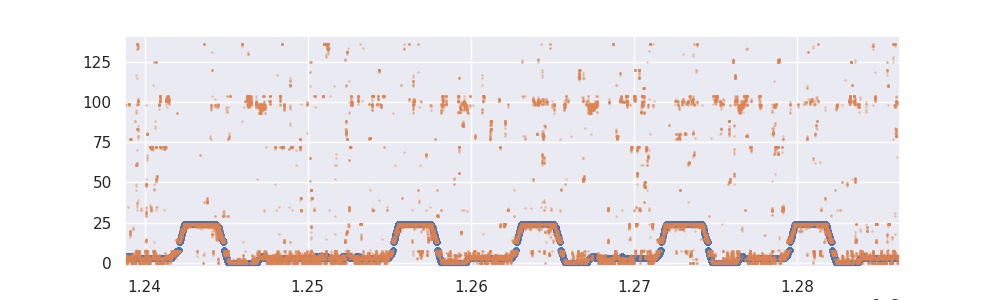

In [10]:
%matplotlib notebook
# plot decoded max posterior and real position
plt.figure(figsize=(10,3))

#post_error_plot_subset = post_error_plot3[(post_error_plot3['timestamp']>124500000) & 
#                                          (post_error_plot3['timestamp']<124700000)]

plt.scatter(post_error_plot['timestamp'].values,post_error_plot['real_pos'].values,s=10)
plt.scatter(post_error_plot['timestamp'].values,post_error_plot['max_position'].values,s=1,alpha=0.3)


In [17]:
# remote error
# only calculate error during movement
#post_error_plot7 = post_error_plot7[post_error_plot7['real_vel']>8]
post_error_plot5 = post_error_plot1.copy()

#arm_coords_rt = [[0,7],[12,23],[28,39],[44,55],[60,71],[76,87],[92,103],[108,119],[124,135]]
# new arm_coords 2-2020: [[0,8],[13,24],[29,40],[45,56],[61,72],[77,88],[93,104],[109,120],[125,136]]
box = post_error_plot5[(post_error_plot5['real_pos']>=0) & (post_error_plot5['real_pos']<=8)]
arm1 = post_error_plot5[(post_error_plot5['real_pos']>=13) & (post_error_plot5['real_pos']<=24)]
arm2 = post_error_plot5[(post_error_plot5['real_pos']>=29) & (post_error_plot5['real_pos']<=40)]
arm3 = post_error_plot5[(post_error_plot5['real_pos']>=45) & (post_error_plot5['real_pos']<=56)]
arm4 = post_error_plot5[(post_error_plot5['real_pos']>=61) & (post_error_plot5['real_pos']<=72)]
arm5 = post_error_plot5[(post_error_plot5['real_pos']>=77) & (post_error_plot5['real_pos']<=88)]
arm6 = post_error_plot5[(post_error_plot5['real_pos']>=93) & (post_error_plot5['real_pos']<=104)]
arm7 = post_error_plot5[(post_error_plot5['real_pos']>=109) & (post_error_plot5['real_pos']<=120)]
arm8 = post_error_plot5[(post_error_plot5['real_pos']>=125) & (post_error_plot5['real_pos']<=136)]
print(arm1.shape[0])
print(post_error_plot5.shape)
# fraction of bins with remote error
box_remote_error = ((box.shape[0] - box[(box['max_position']>=0) & (box['max_position']<=8)].shape[0])/box.shape[0])
arm1_remote_error = ((arm1.shape[0] - arm1[(arm1['max_position']>=13) & (arm1['max_position']<=24)].shape[0])/arm1.shape[0])
arm2_remote_error = ((arm2.shape[0] - arm2[(arm2['max_position']>=29) & (arm2['max_position']<=40)].shape[0])/arm2.shape[0])
arm3_remote_error = ((arm3.shape[0] - arm3[(arm3['max_position']>=45) & (arm3['max_position']<=56)].shape[0])/arm3.shape[0])
arm4_remote_error = ((arm4.shape[0] - arm4[(arm4['max_position']>=61) & (arm4['max_position']<=72)].shape[0])/arm4.shape[0])
arm5_remote_error = ((arm5.shape[0] - arm5[(arm5['max_position']>=77) & (arm5['max_position']<=88)].shape[0])/arm5.shape[0])
arm6_remote_error = ((arm6.shape[0] - arm6[(arm6['max_position']>=93) & (arm6['max_position']<=104)].shape[0])/arm6.shape[0])
arm7_remote_error = ((arm7.shape[0] - arm7[(arm7['max_position']>=109) & (arm7['max_position']<=120)].shape[0])/arm7.shape[0])
arm8_remote_error = ((arm8.shape[0] - arm8[(arm8['max_position']>=125) & (arm8['max_position']<=136)].shape[0])/arm8.shape[0])

#print error values
print(box_remote_error,arm1_remote_error,arm2_remote_error,arm3_remote_error,arm4_remote_error,arm5_remote_error,arm6_remote_error,arm7_remote_error,arm8_remote_error)
box_frac = box.shape[0]/post_error_plot5.shape[0]
arm1_frac = arm1.shape[0]/post_error_plot5.shape[0]
arm2_frac = arm2.shape[0]/post_error_plot5.shape[0]
arm3_frac = arm3.shape[0]/post_error_plot5.shape[0]
arm4_frac = arm4.shape[0]/post_error_plot5.shape[0]
arm5_frac = arm5.shape[0]/post_error_plot5.shape[0]
arm6_frac = arm6.shape[0]/post_error_plot5.shape[0]
arm7_frac = arm7.shape[0]/post_error_plot5.shape[0]
arm8_frac = arm8.shape[0]/post_error_plot5.shape[0]

# fraction of arm-only time
arm1_frac1 = arm1.shape[0]/(post_error_plot5.shape[0]*(1-box_frac))
arm2_frac1 = arm2.shape[0]/(post_error_plot5.shape[0]*(1-box_frac))
arm3_frac1 = arm3.shape[0]/(post_error_plot5.shape[0]*(1-box_frac))
arm4_frac1 = arm4.shape[0]/(post_error_plot5.shape[0]*(1-box_frac))
arm5_frac1 = arm5.shape[0]/(post_error_plot5.shape[0]*(1-box_frac))
arm6_frac1 = arm6.shape[0]/(post_error_plot5.shape[0]*(1-box_frac))
arm7_frac1 = arm7.shape[0]/(post_error_plot5.shape[0]*(1-box_frac))
arm8_frac1 = arm8.shape[0]/(post_error_plot5.shape[0]*(1-box_frac))
#weighted average for box + each arm
print((box_remote_error*box_frac + arm1_remote_error*arm1_frac +arm2_remote_error*arm2_frac +
       arm3_remote_error*arm3_frac +arm4_remote_error*arm4_frac +arm5_remote_error*arm5_frac +
       arm6_remote_error*arm6_frac +arm7_remote_error*arm7_frac +arm8_remote_error*arm8_frac))
# weighted average no box
print((arm1_remote_error*arm1_frac1 +arm2_remote_error*arm2_frac1 +arm3_remote_error*arm3_frac1 +
       arm4_remote_error*arm4_frac1 +arm5_remote_error*arm5_frac1 +arm6_remote_error*arm6_frac1 +
       arm7_remote_error*arm7_frac1 +arm8_remote_error*arm8_frac1))


12259
(177698, 143)
0.20827525785512324 0.18435435190472307 0.15402371209736648 0.3575909661229611 0.25339141257000625 0.23827139734319824 0.181640625 0.3716856060606061 0.2841382415850501
0.22380668324910805
0.24400031066352554


In [ ]:
# local error
# NOTE: need to update arm coords
box_local = box[(box['max_position']>-1) & (box['max_position']<8)]
arm1_local = arm1[(arm1['max_position']>11) & (arm1['max_position']<24)]
arm2_local = arm2[(arm2['max_position']>27) & (arm2['max_position']<40)]
arm3_local = arm3[(arm3['max_position']>43) & (arm3['max_position']<56)]
arm4_local = arm4[(arm4['max_position']>59) & (arm4['max_position']<72)]
arm5_local = arm5[(arm5['max_position']>75) & (arm5['max_position']<88)]
arm6_local = arm6[(arm6['max_position']>91) & (arm6['max_position']<104)]
arm7_local = arm7[(arm7['max_position']>107) & (arm7['max_position']<120)]
arm8_local = arm8[(arm8['max_position']>123) & (arm8['max_position']<136)]

box_local_error = np.median(box_local['error_cm'].values)
arm1_local_error = np.median(arm1_local['error_cm'].values)
arm2_local_error = np.median(arm2_local['error_cm'].values)
arm3_local_error = np.median(arm3_local['error_cm'].values)
arm4_local_error = np.median(arm4_local['error_cm'].values)
arm5_local_error = np.median(arm5_local['error_cm'].values)
arm6_local_error = np.median(arm6_local['error_cm'].values)
arm7_local_error = np.median(arm7_local['error_cm'].values)
arm8_local_error = np.median(arm8_local['error_cm'].values)

print(arm1_local_error,arm2_local_error,arm3_local_error,arm4_local_error,arm5_local_error,arm6_local_error,arm7_local_error,arm8_local_error,)

# total bins with local error
local_total_bins = (arm1_local.shape[0]+arm2_local.shape[0]+arm3_local.shape[0]+arm4_local.shape[0]+
                    arm5_local.shape[0]+arm6_local.shape[0]+arm7_local.shape[0]+arm8_local.shape[0])
local_total_bins
#weighted average for each arm
(arm1_local_error*(arm1_local.shape[0]/local_total_bins)+arm2_local_error*(arm2_local.shape[0]/local_total_bins)+
 arm3_local_error*(arm3_local.shape[0]/local_total_bins)+arm4_local_error*(arm4_local.shape[0]/local_total_bins)+
 arm5_local_error*(arm5_local.shape[0]/local_total_bins)+arm6_local_error*(arm6_local.shape[0]/local_total_bins)+
 arm7_local_error*(arm7_local.shape[0]/local_total_bins)+
 arm8_local_error*(arm8_local.shape[0]/local_total_bins))